### Vi prøver igen ...
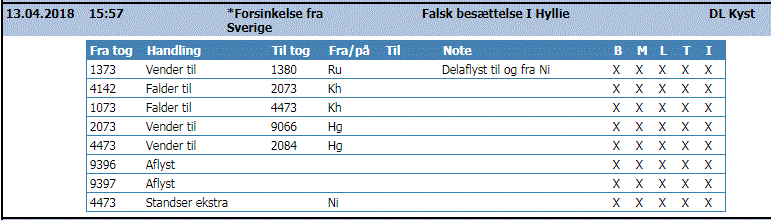
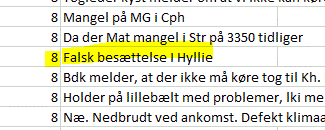

In [1]:
# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')
os.listdir()

['.ipynb_checkpoints',
 'FEDData.xlsx',
 'FEDData_All_texts.xlsx',
 'FEDData_test.xlsx',
 'FEDData_train.xlsx',
 'FEDentry.GIF',
 'FEDentry2.GIF',
 'FED_01_FirstModel.ipynb',
 'FED_02_SplitTrainOgTest.ipynb']

Først laver vi en "dictionary", som omsætter ord til tal. Den bruges efterfølgende til at omsætte train data og test data.

In [2]:
# filen med tekster åbnes og indlæses
file = 'FEDData_All_texts.xlsx'
xl = pd.ExcelFile(file)
df = xl.parse('RaaData_Forespørgsel')

# strenge læses over i en tabel
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# henter text processing modul
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som igen kan laves til en "one-hot)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# en funktion som lave en one-hot vektorer
def vectorize_sequences(sequences, dimension=10000):
    # lave en all-zero matrix af formen (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

In [4]:
# Træningsdata indlæses (tekster og labels), først tekst-strengene
file = 'FEDData_train.xlsx'
xl = pd.ExcelFile(file)
df = xl.parse('RaaData_Forespørgsel')
texts  = df.loc[:,'FEDtext']
labels = df.loc[:,'FEDsize']
texts  = texts.values
labels = labels.values

# ord laves til og der "paddes"
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences)

# One-hot training data
data = vectorize_sequences(data, dimension=max_words)

# labels laves til vektor
labels = np.asarray(labels).astype('float32')

In [17]:
print(data.shape)
print(labels.shape)

(19961, 10000)
(19961,)


In [15]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_17 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(data, labels,
                    epochs=3,
                    batch_size=512,
                    validation_split=0.2)

Train on 9980 samples, validate on 9981 samples
Epoch 1/3
9980/9980 [==============================] - 2s 197us/step - loss: 0.0183 - acc: 0.9941 - val_loss: 0.0461 - val_acc: 0.9885
Epoch 2/3
9980/9980 [==============================] - 2s 194us/step - loss: 0.0176 - acc: 0.9939 - val_loss: 0.0471 - val_acc: 0.9885
Epoch 3/3
9980/9980 [==============================] - 2s 188us/step - loss: 0.0170 - acc: 0.9943 - val_loss: 0.0483 - val_acc: 0.9880


In [53]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

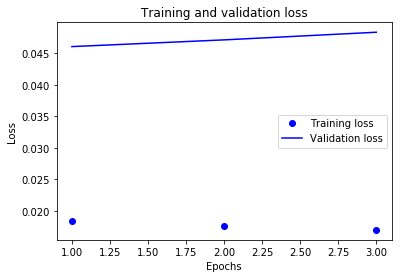

In [58]:
import matplotlib.pyplot as plt

accu = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs = range(1, len(history_dict['binary_accuracy']) + 1)
epochs = range(1, 4)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

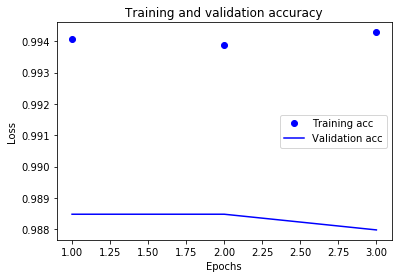

In [59]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [60]:
# Træningsdata indlæses (tekster og labels), først tekst-strengene
file = 'FEDData_test.xlsx'
xl = pd.ExcelFile(file)
df = xl.parse('RaaData_Forespørgsel')
texts_test  = df.loc[:,'FEDtext']
labels_test = df.loc[:,'FEDsize']
FEDid_test  = df.loc[:,'FEDid']
texts_test  = texts_test.values
labels_test = labels_test.values
FEDid_test  = FEDid_test.values

# ord laves til og der "paddes"
sequences_test = tokenizer.texts_to_sequences(texts_test)
data_test = pad_sequences(sequences_test)

# One-hot training data
data_test = vectorize_sequences(data_test, dimension=max_words)

# labels laves til vektor
labels_test = np.asarray(labels_test).astype('float32')

In [61]:
# vi prøver modellen på test-data
predictions = model.predict(data_test)

# vi printer min, max og nogle eksempler
print(min(predictions), max(predictions))
SplitVal = (min(predictions) + max(predictions))/2
print(predictions[1:20])

[0.] [1.]
[[1.692e-06]
 [1.475e-03]
 [7.877e-05]
 [4.319e-10]
 [1.827e-05]
 [2.940e-03]
 [3.314e-07]
 [1.454e-02]
 [1.451e-10]
 [2.414e-12]
 [6.056e-06]
 [1.806e-05]
 [6.704e-14]
 [5.585e-04]
 [4.870e-07]
 [5.861e-03]
 [8.205e-10]
 [2.000e-01]
 [1.530e-17]]


In [56]:
print('Antal store i datasættet:    ', sum(labels_test))

NumEstimated = 0
for i in range(1,6000):
    if predictions[i]>0.01 and FEDid_test[i]<=493:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)

print('Modellens præcision:         ', round(NumEstimated/sum(labels_test)*100), '%')

Antal store i datasættet:     113.0
antal estimeret af modellen:  39
Modellens præcision:          35.0 %


In [68]:
for i in range(1,6000):
    if labels_test[i]==1:
        print(i+2, predictions[i], texts_test[i])    # i+2 er linjen i regnearket

7 [1.827e-05] Genopretning efter fjernstyringsfejlen på sjælland KYST
18 [0.006] Holder nedbrudt i OH  MAteriel fra 2238
30 [3.526e-10] Fortsat spærret Lk - Es, nu til fredag kl 08:00
101 [9.635e-14] Fejl på tysk radio, vi kan ikke få fejl væk, trods flere forsøg, så der omdisponeres.
207 [0.248] Nedformeringer fra sverige.

Der skiftes strømaftager
318 [8.986e-13] Overgravet kabel. Standardprognose hvert i fald fem timer (fra kl. 11.00 hvor fejlsøgning startede).  Alle Lyntog Ar-Ab-Ar aflyses til kl. 16.00.





•	Plan for indgriben: Ja, se nedenf
384 [0.14] Nedformering fra Sverige
480 [5.294e-05] Nu kan der kun køres i et spor i Cph
515 [0.13] Nedformeringer på kystbanen
532 [9.088e-09] Vi aflyser 4419 /4430 pga. mat kommer fra 4106 som holder bag L6 i Gl
573 [7.97e-06] Falsk besættelse Kk - Kn
596 [0.468] Nedformeringer til og fra Sverige.
624 [1.877e-06] Overgravet kabel lige syd for Randers
634 [4.06e-05] 03:47 - Ált strøm er gået i Aarhus, men systemet er ved at genstarte
656 [0